## Стратегия по удержанию клиентов

### Задачи проекта

Имеем результаты анкетирований клиентов фитнес-центра. На их основе нужно решить поставленные задачи.
- Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - Выделить целевые группы клиентов;
    - Предложить меры по снижению оттока;
    - Определить другие особенности взаимодействия с клиентами.

### Этапы проекта

1. Общая информация и предобработка;
2. Исследовательский анализ;
3. Прогнозирование оттока пользователей;
4. Кластеризация (выделение сегментов);
5. Выводы;
6. Рекомендации.

### Данные

Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце
- Текущие поля в датасете:
    - Данные пользователя за предыдущий до проверки факта оттока месяц:
        - 'gender' — пол (0-женщины, 1-мужчины)
        - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
        - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
        - 'Phone' — наличие контактного телефона
        - 'Age' — возраст
        - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
        - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
        - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
        - 'Group_visits' — факт посещения групповых занятий
        - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
        - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
        - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### Общая информация и предобработка

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from seaborn import barplot

In [2]:
data = pd.read_csv('')# удалил в целях безопасности
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Приведем все названия колонок к нижнему регистру. Сократим названия некоторых из них. Посмотрим на общую информацию по данным

In [3]:
data = data.rename(columns={'Avg_class_frequency_total' : 'avg_freq_total', 'Avg_class_frequency_current_month' : \
                            'avg_freq_month', 'Avg_additional_charges_total' : 'avg_charges_total'})
data.columns = map(str.lower, data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 4000 non-null   int64  
 1   near_location          4000 non-null   int64  
 2   partner                4000 non-null   int64  
 3   promo_friends          4000 non-null   int64  
 4   phone                  4000 non-null   int64  
 5   contract_period        4000 non-null   int64  
 6   group_visits           4000 non-null   int64  
 7   age                    4000 non-null   int64  
 8   avg_charges_total      4000 non-null   float64
 9   month_to_end_contract  4000 non-null   float64
 10  lifetime               4000 non-null   int64  
 11  avg_freq_total         4000 non-null   float64
 12  avg_freq_month         4000 non-null   float64
 13  churn                  4000 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков нет, типы данных в порядке. Можно переходить к следующему этапу!

### Исследовательский анализ

Посмотрим на среднее значение, стандартное отклонение в данных

In [4]:
data.loc[:,'age' : 'avg_freq_month'].describe()

,age,avg_charges_total,month_to_end_contract,lifetime,avg_freq_total,avg_freq_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Посетители финес-клуба не старше 41, средний возраст 29 лет. В основном клиенты тратят на доп услуги около 140 рублей ежемесячно. Примечательно, что эта сумма не превосходит 550 рублей среди всех клиентов. Клуб посещают в среднем 2 раза в неделю, хотя находятся люди, которые делают это 6 раз.

Посмотрим на распределение средних значений признаков по ушедшим и неушедшим

In [5]:
sample0 = data.loc[data['churn']==0, 'age' : 'avg_freq_month']
sample1 = data.loc[data['churn']==1, 'age' : 'avg_freq_month']
y0, y1 = [], []
x = np.arange(len(sample0.columns))
width = 0.4
for col in sample0.columns:
    y0.append(sample0[col].mean())
    y1.append(sample1[col].mean())

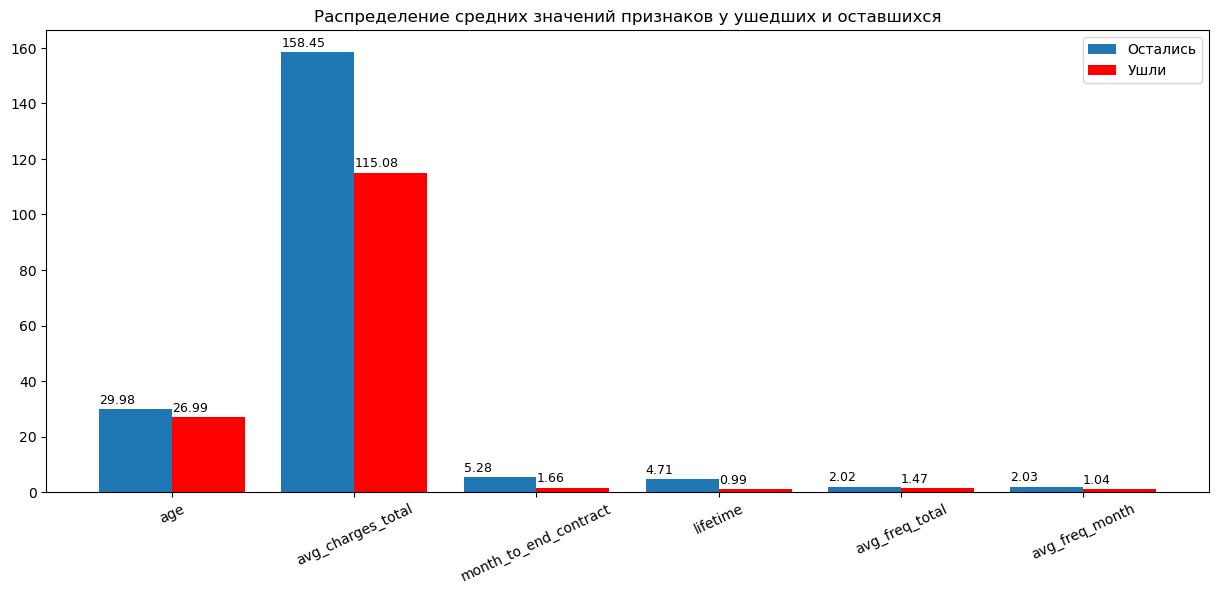

In [6]:
plt.figure(figsize=(15,6))   
pl0 = plt.bar(x-0.2, y0, width)
pl1= plt.bar(x+0.2, y1, width, color='red')
plt.legend(['Остались', 'Ушли'])
plt.xticks(x, sample0.columns, rotation = 25)
plt.title('Распределение средних значений признаков у ушедших и оставшихся')

for bar in pl0:
    plt.annotate(round(bar.get_height(), 2), 
                 xy=(bar.get_x(), bar.get_height()+2), 
                     fontsize=9)
for bar in pl1:
    plt.annotate(round(bar.get_height(), 2), 
                 xy=(bar.get_x(), bar.get_height()+2), 
                     fontsize=9)
plt.show()

Видно, что ушедшие клиенты меньше тратили на доп услуги фитнес-клуба. Примечательно, что клиенты уходят в среднем через месяц после первого посещения. Ушедшие клиенты посещали фитнес-клуб реже, чем оставшиеся.

Теперь посмотрим на распределения признаков

In [7]:
sample0 = data.loc[data['churn']==0].drop(columns='churn')
sample1 = data.loc[data['churn']==1].drop(columns='churn')

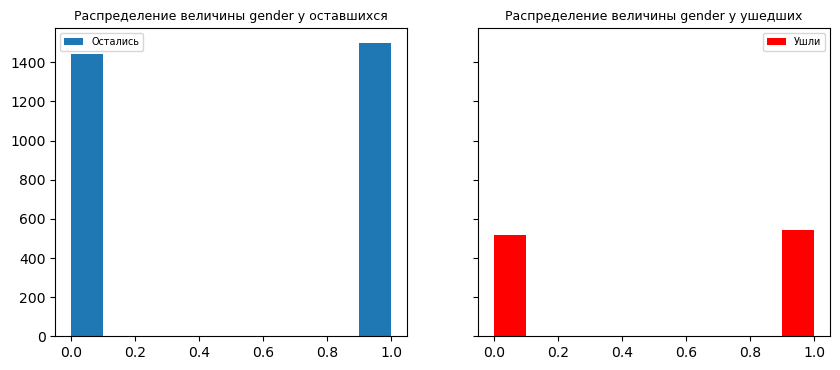

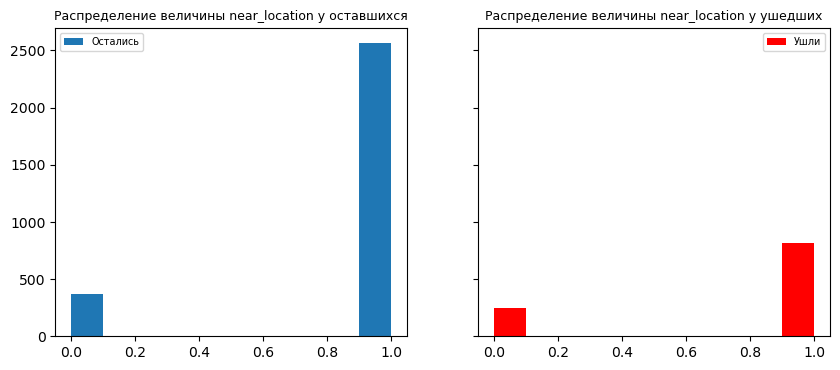

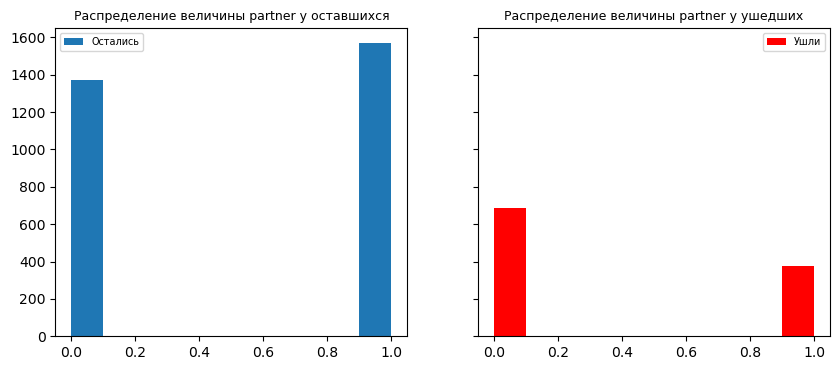

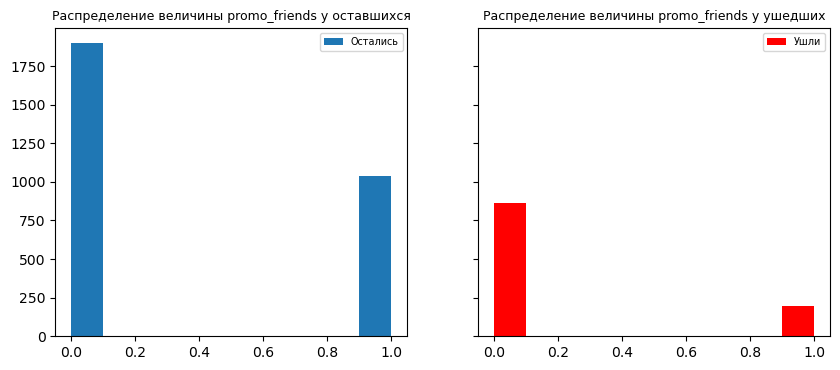

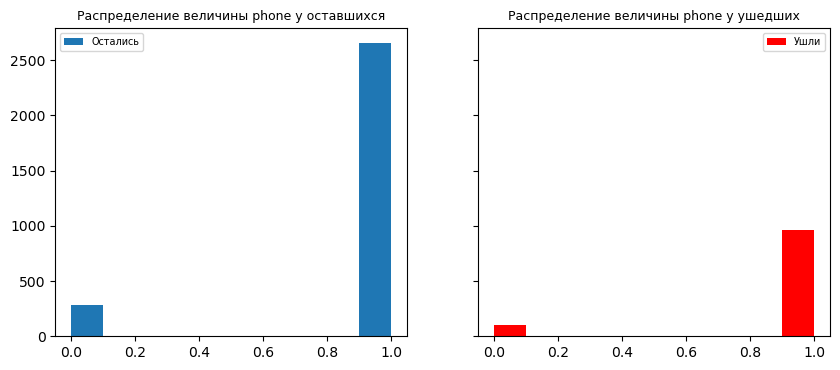

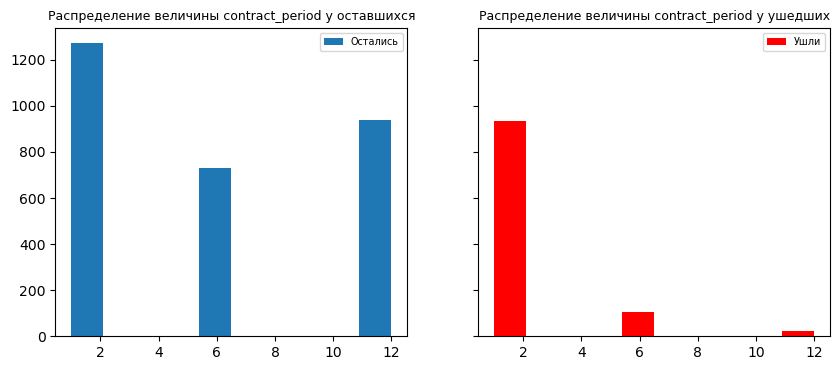

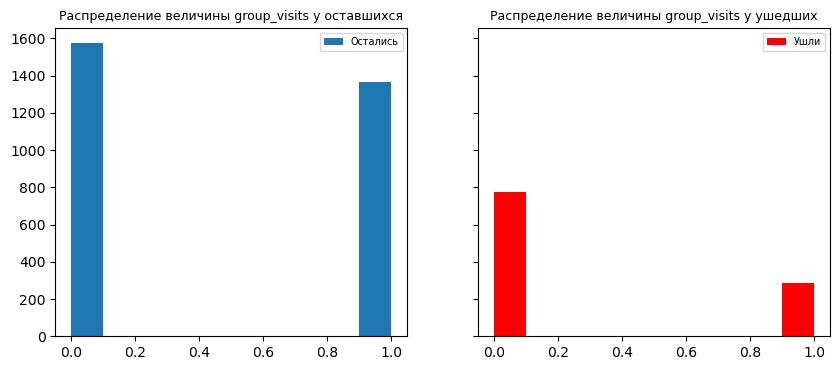

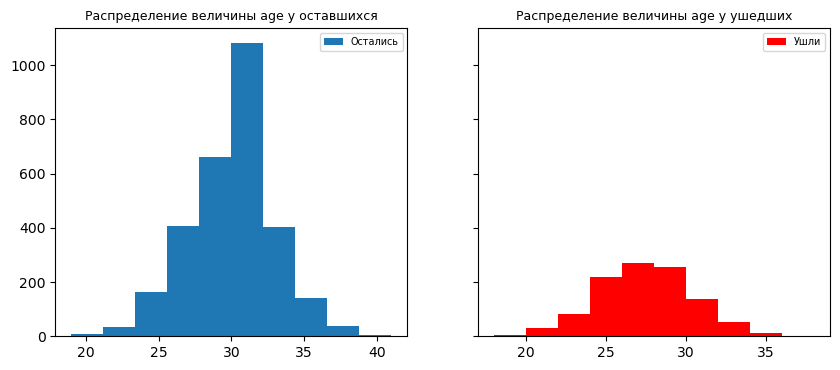

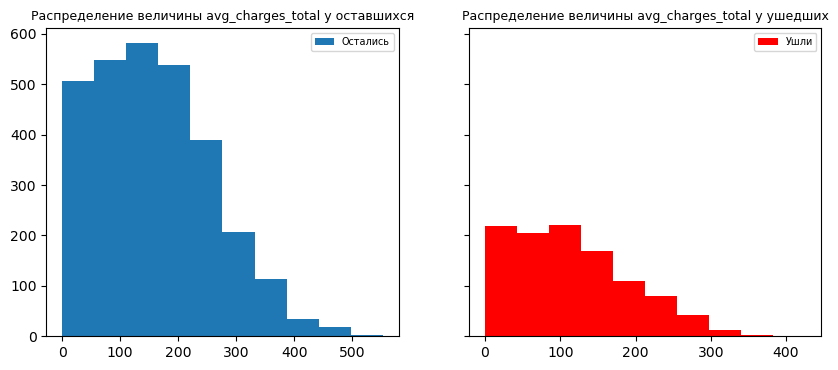

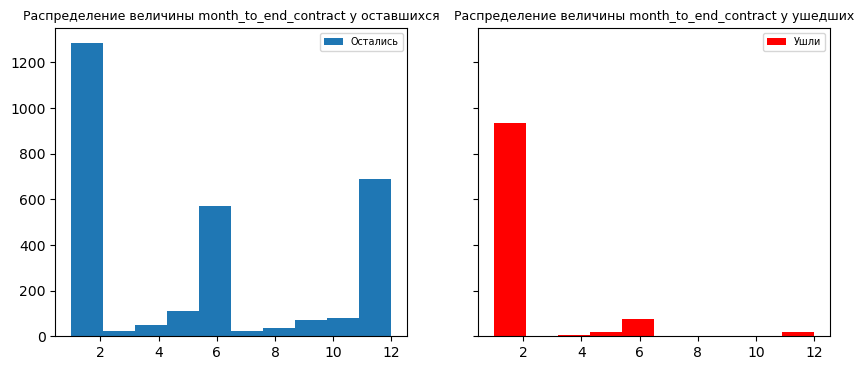

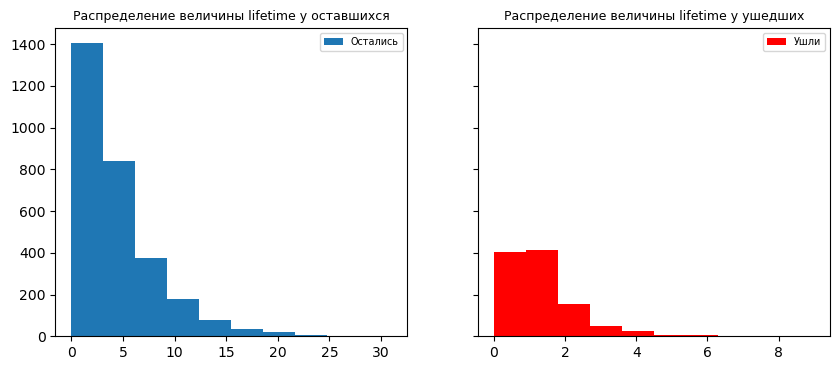

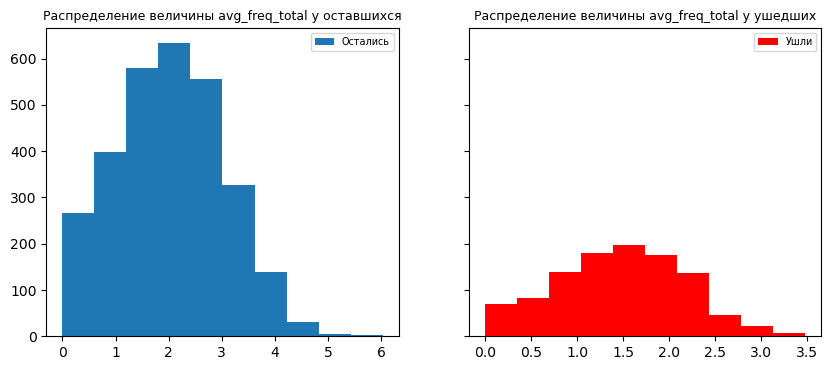

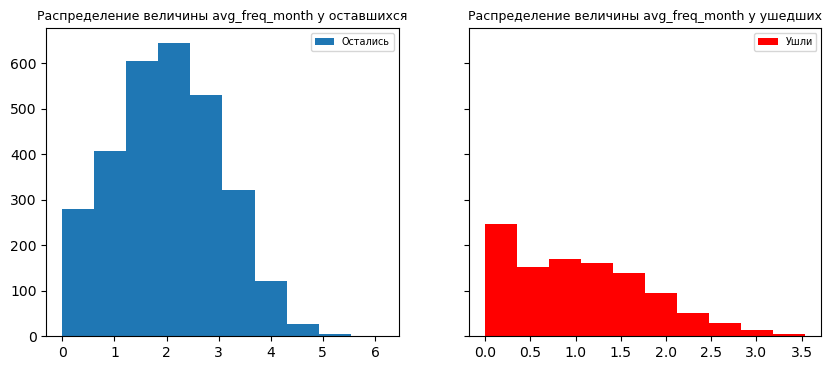

In [8]:
for col in sample0.columns:
    fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2, sharey=True)
    ax[0].hist(sample0[col], label='Остались')
    ax[0].legend(['Остались'], fontsize=7)
    ax[1].hist(sample1[col], color='red', label='Ушли')
    ax[0].set_title(f'Распределение величины {col} у оставшихся', fontsize=9)
    ax[1].set_title(f'Распределение величины {col} у ушедших', fontsize=9)
    ax[1].legend(['Ушли'], fontsize=7)
    plt.show()

Аномалий в данных нет. Среди оставшихся клиентов видим большой пик людей 28-32 лет. что касается уходящих клиентов, то преимущественно они покидают фитнес-клуб, когда остается 1 месяц до конца абоненмента.

Построим матрицу корреляций
<a id='corr'></a>

In [9]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_charges_total', 'month_to_end_contract', 'lifetime', 'avg_freq_total', 'avg_freq_month', 'churn']


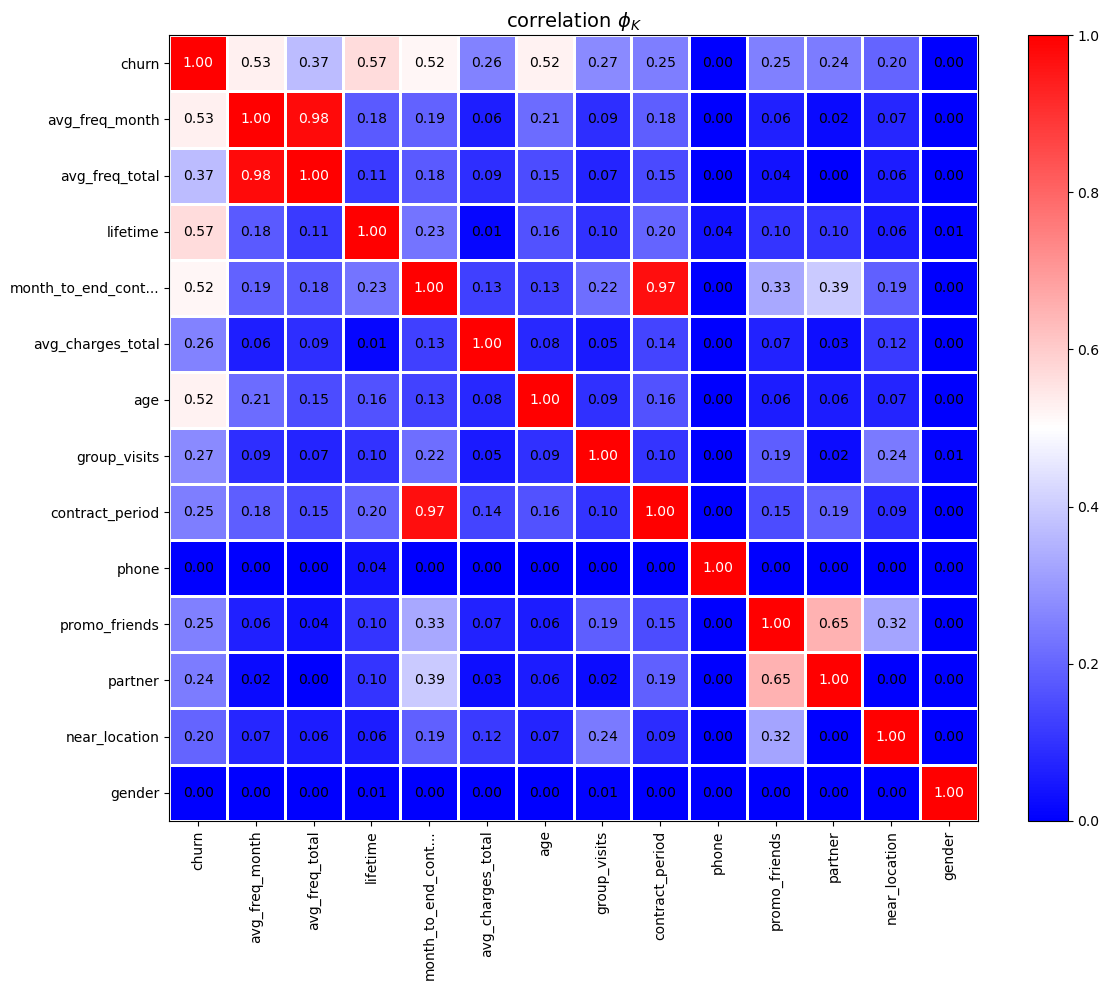

In [10]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='bwr', 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1, 
                        figsize=(12, 10))
plt.tight_layout()

Видим, что на факт оттока больше всего влияют следующие признаки: время с момента первого обращения в фитнес-клуб, среднее количество посещений в текущем месяце, кол-во месяцев до окончания текущего абонемента и возраст, а вот гендер и наличие контактного телефона абсолютно не влияют на отток. <br>Между собой очень сильно коррелируют: среднее кол-во посещений в неделю за последний месяц и среднее кол-во посещений в неделю за все время, длительность текущего действующего абонемента и  срок до окончания текущего действующего абонемента.

### Прогнозирование оттока пользователей

Будем прогнозировать с помощью логистической регрессии и случайного леса

Для начала разобьем данные на обучающую и валидационную выборки и стандартизируем их

In [11]:
X = data.drop(columns=['churn'])
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обозначим модели

In [12]:
model_regr = LogisticRegression(random_state=0,solver='liblinear', class_weight='balanced')
model_forest = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=100)

Обучим модели

In [13]:
model_regr.fit(X_train_st, y_train)
model_forest.fit(X_train_st, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

Сделаем прогнозы и оценим метрики. Главной метрикой для нас является **Recall**, так как эта метрика позволит свести к минимуму ложноотрицательные прогнозы и не упустить клиентов, которые на самом деле могут уйти.

In [14]:
def metrics(y_test, predictions):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

In [15]:
y_regr_pred = model_regr.predict(X_test_st)
y_forest_pred = model_forest.predict(X_test_st)
print('LogisticRegression:')
metrics(y_test, y_regr_pred)
print()
print('RandomForestClassifier:')
metrics(y_test, y_forest_pred)

LogisticRegression:
Accuracy: 0.91
Precision: 0.76
Recall: 0.91

RandomForestClassifier:
Accuracy: 0.91
Precision: 0.84
Recall: 0.80


После настройки моделей, по метрике recall логистическая классификация показывает себя лучше. Посмотим на площадь под кривой, чтобы оценить вероятности принадлежности к классу

In [16]:
probabilities = model_regr.predict_proba(X_test_st)[:,1]
print('LogisticRegression ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

LogisticRegression ROC_AUC: 0.97


In [17]:
probabilities = model_forest.predict_proba(X_test_st)[:,1]
print('RandomForestClassifier ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

RandomForestClassifier ROC_AUC: 0.97


Обе модели очень уверенно определяеют класс объектов

### Сделаем кластеризацию клиентов

Нарисуем дендограмму, чтобы предположить примерное количество кластеров, но сначала стандартизируем данные

In [18]:
sc = StandardScaler()
X_st = sc.fit_transform(X)

In [19]:
linked = linkage(X_st, method = 'ward') 

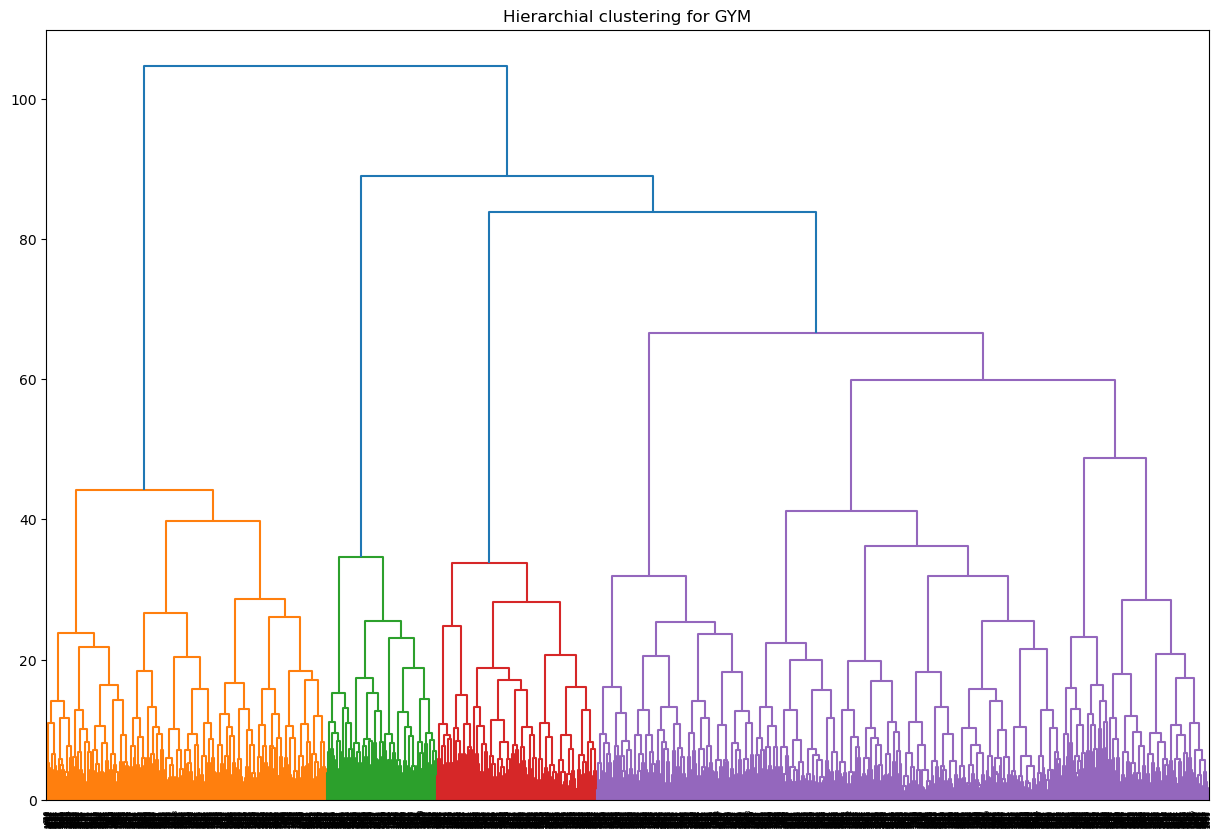

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

На основе дендограммы можно выделить 4-5 кластеров. Сделаем это!

In [21]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)

Добавим в наш датасет выделенные кластеры

In [22]:
data['cluster'] = labels

Посмотрим на средние значения признаков по кластерам

In [23]:
pivot = pd.pivot_table(data=data, columns='cluster', values=['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age', 'avg_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_freq_total', 'avg_freq_month',
       'churn'], aggfunc='mean').T.reset_index()

In [24]:
pivot

,cluster,age,avg_charges_total,avg_freq_month,avg_freq_total,churn,contract_period,gender,group_visits,lifetime,month_to_end_contract,near_location,partner,phone,promo_friends
0,0,29.982178,160.761016,1.974789,1.982055,0.027723,10.889109,0.502970,0.542574,4.736634,9.954455,0.959406,0.783168,1.000000,0.574257
1,1,29.301299,143.957664,1.716369,1.847220,0.267532,4.787013,0.522078,0.425974,3.924675,4.475325,0.862338,0.470130,0.000000,0.306494
2,2,28.477228,135.457501,1.477324,1.660461,0.443564,2.352475,0.495050,0.215842,2.809901,2.198020,0.000000,0.463366,1.000000,0.079208
3,3,28.167987,131.622204,1.012983,1.247634,0.514263,1.948494,0.485737,0.341521,2.440571,1.856577,1.000000,0.350238,1.000000,0.240095
4,4,30.125298,161.657905,2.850161,2.852002,0.068019,2.669451,0.559666,0.473747,4.898568,2.459427,0.976134,0.356802,0.998807,0.230310


Сразу отметим, что по результатам в каждом кластере примерно равные доли мужчин и женщин. Посмотрим распределение остальных признаков

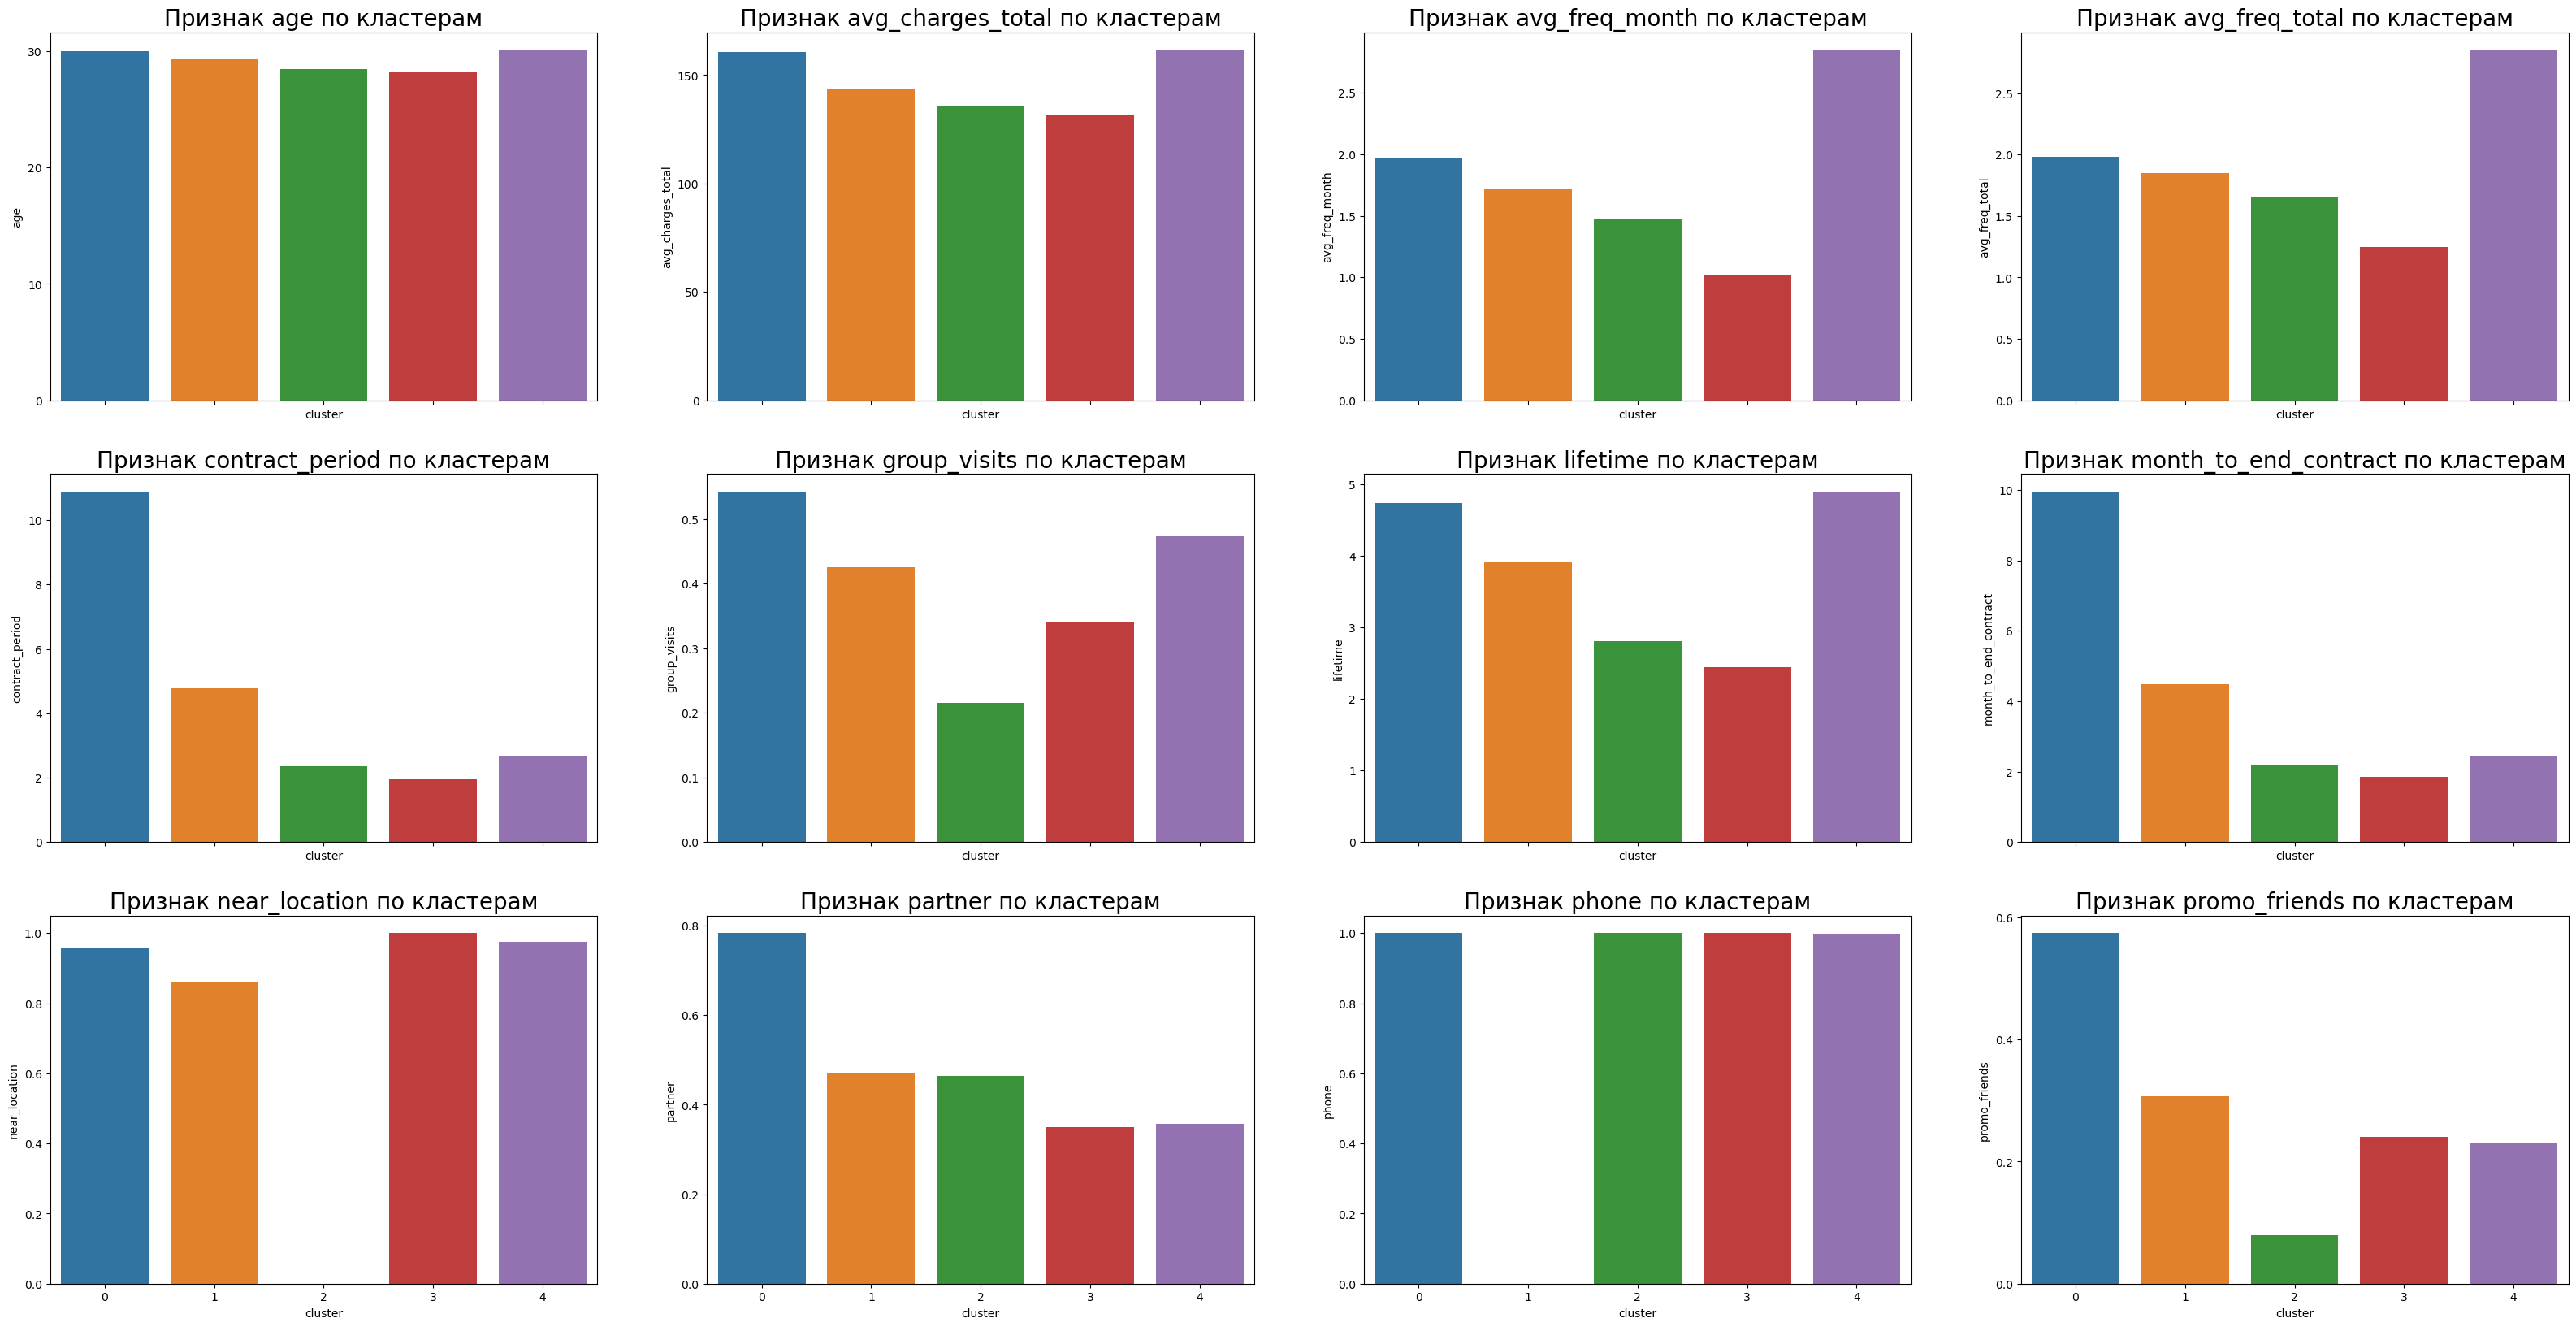

In [25]:
fig, ax = plt.subplots(3, 4, sharex=True, figsize=(40, 20))
k=1
for i in range(0,3):
    for j in range(0,4):
        col = pivot.columns.tolist()[k]
        k+=1
        if col == 'churn' or col == 'gender':
            col = pivot.columns.tolist()[k]
            k+=1
        barplot(data=pivot, x='cluster', y=col, ax=ax[i,j])
        ax[i, j].set_title(f'Признак {col} по кластерам', fontsize=20)
plt.rcParams['font.size'] = '26'
plt.show()

Уже сейчас видно, что по кластерам значительно отличаются все признаки кроме возраста и трат на доп. услуги. Посмотрим на отток по кластерам

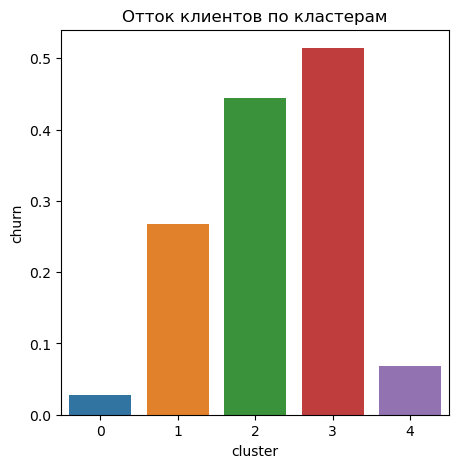

In [26]:
plt.rcParams['font.size'] = '10'
plt.figure(figsize=(5,5))
pl0 = sns.barplot(data=pivot, x='cluster', y='churn')
plt.title('Отток клиентов по кластерам')


plt.show()

Видим, что 1,2 и 3 кластеры имеют приличные доли оттока: 27%, 44% и 51% соответственно. **Теперь можем выделить окончательные сегменты**

Вспомним, какие признаки имеют значительную корреляцию с фактом оттока. Обратимся к нашей [матрице корреляций](#corr)

Исследование показало, что к оттоку из фитнес клуба наиболее склонны следующие сегменты целевой аудитории:<br>
**Сегмент 1, отток 27%**
- Средний возраст около 30 лет
- Траты на доп услуги около 144 рублей
- В среднем 1-2 посещения в неделю
- До конца действия абонемента 4 месеца
- Групповые занятия посещает 40% сегмента
- Прошло около 3-4 месяца с последнего обращения

**Сегмент 2, отток 44%**
- Средний возраст около 30 лет
- Траты на доп услуги около 135 рублей
- В среднем 1-2 посещения в неделю
- До конца действия абонемента 2 месеца
- Групповые занятия посещает 20% сегмента
- Прошло около 2-3 месяца с момента последнего обращения

**Сегмент 3, отток 51%**
- Средний возраст около 30 лет
- Траты на доп услуги около 131 рублей
- В среднем 1 посещение в неделю
- До конца действия абонемента менее 2 месецов
- Групповые занятия посещает 35% сегмента
- Прошло около 2 месяца с момента последнего обращения

Также, разберемся с возрастом. По кластерам он примерно одинаковый, но матрица корреляций утверждает, что он влияет на отток

In [27]:
per = round(data[data['age']<=28]['churn'].sum()*100 / data[data['age']<=28]['churn'].count(), 2)
f'Отток клиентов до 28 лет равен {per}%'

'Отток клиентов до 28 лет равен 44.55%'

In [28]:
per = round(data[data['age']>28]['churn'].sum()*100 / data[data['age']>28]['churn'].count(), 2)
f'Отток клиентов старше 28 лет равен {per}%'

'Отток клиентов старше 28 лет равен 13.72%'

Видим, что почти каждый второй клиент в возрасте до 28 лет покидает фитнес-клуб, а вот люди 28+ к нам более лояльны

### Выводы

Перед нами стояла задача спрогнозировать факт оттока клиентов фитнес-клуба, выделить среди них сегменты и выяснить, что становится причиной потери клиента. <br>

Прежде всего, **мы изучили общую информацию и провели предобработку данных**. Данные оказались комфортными для последующей работы, поэтому этот этап не потребовал больших усилий. На этапе **исследовательского анализа** мы посмотрели на распределение признаков и построили **матрицу корреляций**. Оказалось, что в данных есть признаки, которые значительно влияют на отток клиентов. Например, частота посещений с неделю, возраст и количество месяцев до конца срока действия абонемента. <br>

Далее мы спрогнозировали отток клиентов. Особое внимание уделили метрике **Recall**, ведь нам важно было сократить число случаев, когда мы прогнозируем, что клиент останются, но на самом деле он покидает фитнес-клуб. Алгоритм **логистической регрессии** показал себя лучше, чем **случайный лес**. Recall 0,91 против 0,80 соответственно.

Затем мы провели **кластеризацию**, выделив 5 кластеров. Было выделено 3 **сегмента** клиентов, отток в которых составил 27%, 44% и 51%, и сформированы **портеты** представителей этих сегментов. Также, мы обратили внимание на то, что 45% клиентов **в возрасте до 28 лет** склонны покидать наш фитнес-клуб, в то время как у клиентов **старше 28 лет** отток составил 14%.

### Рекомендации

Анализ показал, что хорошо удерживаются клиенты, которые вовлечены в **посещение групповых занятий**. Тогда необходимо продвигать групповые занятия, предлагая выгодные условия для их посещения.
- Вовлечение клиентов в групповые занятия

Одной из причин оттока стала незаинтересованность клиентов в **дополнительных услугах** клуба. Сегмент 3, представители которого тратят в среднем меньше других на доп. услуги, имеет самую большую долю ушедших. Необходимо заинтересовать клиентов в наших доп. услугах. Например, скидки, подарки и розыгрыши.
- Продвижение дополнительных услуг фитнес-клуба

Выявлено, что тем дольше срок действия текущего абонемента, тем лучше удерживаются клиенты. Разумно предлагать для клиентов выгодные условия для покупки долгосрочных абонементов. 
- Предложение долгосрочных абонементов

Были представлены **рекомедации**, которые основываются на закономерностях, влияющих на отток клиентов, и помогут фитнес-клубу увеличить **Retention rate**.